In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import ee
import xee
import geemap
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
from shapely.geometry import box
from scipy.signal import savgol_filter
import rasterio
from rasterio.features import rasterize
from osgeo import gdal
import rioxarray

from func_mask import get_s2, add_cld_shdw_mask, apply_mask, addNDVI
from func_processing import time_series


In [3]:
try:
    #ee.Initialize()
    ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
except:
    ee.Authenticate()

# Downloading time series
In this Jupyter notebook, raster time series are downloaded with the Xarray Earth Engine (XEE) package.

## Settings

In [66]:
# Voor twee jaar
start = '2021-11-01' # iets langer dan period of interest zodat we kunnen interpoleren
end = '2025-01-15'

start_wdw = '2022-02-01' # de echte period of interest
end_wdw = '2024-09-01'

vi_str = 'ndvi' # welke vegetatie-index
sg_filter = False # gebruik van een Savitzky-Golay filter 

output_folder = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/rasters-telcirkels-mas'
export = True

## Reading geometries (telcirkels)
Processing of the geometries was done in R script 01-process-geometries.R. Outputs were written to shared Q-drive. These processed geometries are now loaded here, so that they can be used in xarray earth engine. The counting points stay the same over the years, this means that we will download the required imagery for all years we want (e.g. 2022 and 2023) at the same time.

In [28]:
#Read telcirkels
#  CRS to 4326!!

tc = gpd.read_file('../data/processed/telcirkels_viz.gpkg')
tc = tc.to_crs(epsg=4326)
tc.head(5)

,pointid,sample_order,batch,regio,area_prop_sb,openheid_klasse,sbp,crs,geometry
0,Km_10019,1.0,eerste set,Kempen,0.001557,HOL,binnen,31370,"POLYGON ((5.46512 51.10721, 5.46511 51.10707, ..."
1,Km_10056.3,5.0,eerste set,Kempen,0.000000,HOL,binnen,31370,"POLYGON ((5.42861 51.06523, 5.42860 51.06509, ..."
2,Km_10910,57.0,eerste set,Kempen,0.000000,HOL,binnen,31370,"POLYGON ((5.75928 51.16607, 5.75927 51.16593, ..."
3,Km_12411.5,41.0,eerste set,Kempen,0.000000,HOL,binnen,31370,"POLYGON ((4.77799 51.10468, 4.77798 51.10454, ..."
4,Km_13799.2,45.0,eerste set,Kempen,0.000000,HOL,binnen,31370,"POLYGON ((4.92203 51.38162, 4.92203 51.38148, ..."


In [ ]:
## testje
#tc = tc.loc[tc.pointid.isin(['Lm_11070','Lm_11568.1','Lm_15064.9', 'Lm_8486.3', 'Lm_8898.1.8', 'Lm_9709.1.6'])]
#tc = tc.reset_index(drop=True)

## redownload

# Which points should be redownloaded?
path = output_folder
files_list = os.listdir(path)

size_of_file = [
    (f, os.stat(os.path.join(path, f)).st_size) for f in files_list
]

In [59]:
# Iterate over list of files along with size 
# and print them one by one.

tc_to_redownload = [tc[0] for tc in size_of_file if tc[1]<4000000]
tc_names = [tc.lstrip('multiband_raster_ndvi_').rstrip('_sg.tif') for tc in tc_to_redownload]
print(tc_names)

tc = tc.loc[tc.pointid.isin(tc_names), ].reset_index()


['Km_11579.15', 'Km_14303.4', 'Km_15471.15', 'Km_17707.4', 'Km_34481.16', 'Km_36692.1.3', 'Km_42618.2.4', 'Km_48264.3', 'Km_50820.1', 'Ol_11033.1', 'Ol_8799.1', 'Ol_8888.15', 'Pl_10832', 'Pl_10846.13', 'Pl_14393.14', 'Pl_14538.6', 'Pl_16660.1.25', 'Pl_25135.1.3', 'Pl_26857.1.3', 'Pl_33161.1', 'Pl_8014.4', 'VL0617', 'Zn_12642.1.23', 'Zn_14605.2', 'Zn_20591.9', 'Zn_2942', 'Zn_70022.6', 'Zn_879.2', 'Zn_88997.4', 'Zn_8985.6']


## Processing for-loop
- Getting time series for every counting point, for all years at once
- Exporting them

In [68]:
# Loop over every telcirkel, for each one, data
sg_name = '_sg' if sg_filter == True else ''
failed_downloads = list()

for i in range(tc.shape[0]): #
    # create a bbox and convert to right format for extracting time series
    pointid = tc.loc[i,'pointid']
    shape = tc.loc[i,'geometry']


    # Create time series with custom function
    da = time_series(start, end, start_wdw, end_wdw, shape, vi_arg = vi_str, sg = sg_filter) #input= 'EPSG:4326', output = 'EPSG:32631'
    da.rio.set_spatial_dims('X', 'Y', inplace=True)

    #-- EXPORT
    if export == True:
        # Rename dimensions to conform to rioxarray requirements
        da = da \
        .rename({'Y': 'y', 'X': 'x'}) \
        .transpose('time', 'y', 'x') \
        .rio.write_crs("EPSG:32631")


        # Specify the output file path & export as GTiff

        output_file = f'multiband_raster_{vi_str}_{pointid}{sg_name}.tif'
        output_path = os.path.join(output_folder, output_file)

        try:
            da.rio.to_raster(output_path, driver='GTiff', tiled=True, compress='LZW')

            # Band renaming with GDAL (to store the dates)
            gdal.UseExceptions()

            # Define band names (these should be in the order of your bands)
            band_names = [str(time).split('T')[0] for time in da.time.values]

            # Open the dataset in update mode
            dataset = gdal.Open(output_path, gdal.GA_Update)

            if dataset:
                for i, name in enumerate(band_names, start=1):
                    band = dataset.GetRasterBand(i)
                    if band:
                        band.SetDescription(name)  # Set the band name

                dataset = None  # Close the dataset to flush changes
            else:
                print("Error opening file")
        except:
            print(f'Download failed for pointid {pointid}')
            failed_downloads.append(pointid)

crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631
crs roi EPSG:32631


## Postprocessing
For 30 points there were NA values left in the time series, therefore no savgol function could be applied. So I downloaded these time series separately, without applying the savgol filter. Here, I want to apply some postprocessing (i.e. the same savgol filter applied to all other time series) to these points. 

Goal is to apply to only the time series with no NA values

(array([3.00000e+00, 4.30000e+01, 3.09900e+03, 4.63600e+04, 6.73120e+04,
        5.54320e+04, 6.16170e+04, 7.66250e+04, 1.05676e+05, 4.88810e+04]),
 array([-0.1354226 , -0.02494588,  0.08553084,  0.19600756,  0.30648428,
         0.41696101,  0.52743775,  0.63791448,  0.74839115,  0.85886788,
         0.96934462]),
 <BarContainer object of 10 artists>)

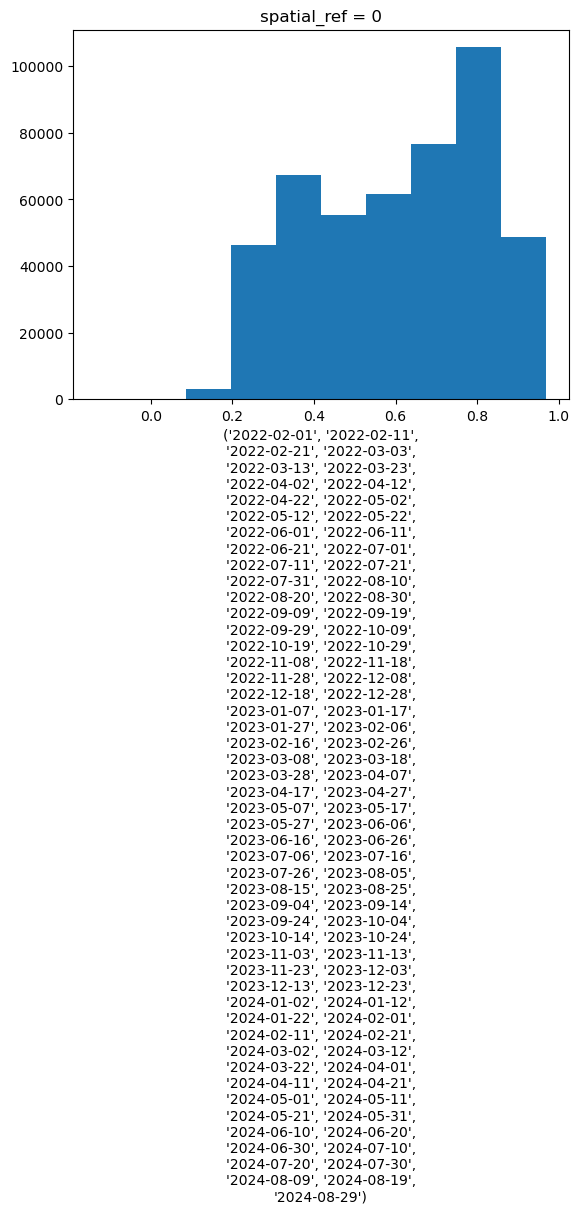

In [ ]:
import xarray as xr
import rioxarray as rxr
from scipy.signal import savgol_filter
import numpy as np

# List all files that don't end with '_sg' (=savgol)
rasters = [file for file in os.listdir(output_folder) if not file.endswith('_sg.tif')]

raster_arr = rxr.open_rasterio(os.path.join(output_folder, rasters[0]))

# List functions
def apply_savgol_to_1d(arr, window_length, polyorder):
    """
    Applies the Savitzky-Golay filter to a 1D numpy array,
    ignoring NaN values.
    """
    if np.isnan(arr).all():
        return arr
    
    # Get indices of non-NaN values
    not_nan_indices = ~np.isnan(arr)
    
    # Apply filter to non-NaN values
    filtered_values = savgol_filter(arr[not_nan_indices], window_length, polyorder)
    
    # Create an output array with the original size
    output_arr = np.full_like(arr, np.nan)
    
    # Place filtered values back in their original positions
    output_arr[not_nan_indices] = filtered_values
    
    return output_arr

def savgol_filter_xr(da, dim, window_length, polyorder):
    """
    Applies the Savitzky-Golay filter to an xarray.DataArray along a specified dimension,
    handling NaN values.
    """
    return xr.apply_ufunc(
        apply_savgol_to_1d,
        da,
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
        exclude_dims={dim},
        kwargs={"window_length": window_length, "polyorder": polyorder},
        dask='parallelized',
        output_dtypes=[da.dtype],
        vectorize=True
    )

# Assuming 'raster_arr' is your rioxarray DataArray
# and the time dimension is named 'time'
window_length = 5
polyorder = 2

# Apply the savgol filter
filtered_raster = savgol_filter_xr(raster_arr, 'time', window_length, polyorder)

# Save the filtered raster
# filtered_raster.rio.to_raster(os.path.join(output_folder, 'filtered_raster_sg.tif'))